In [1]:
# This Notebook contains contents for Data Science Assessment (with Fraud Data).
# Main Contents are as follows:
# 1. Preliminaries
# 2. Exploration of dataset  
# 3. Improvement steps
# 4. Prediction of holdout data


#1. Preliminaries
#1. 1) Importing packages and Loading Dataset
import numpy as np
import pandas as pd
import torch 
import sklearn
import imblearn
from imblearn.over_sampling import ADASYN
# Monkey patch for fixing error importing LogisticRegression function
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


# csv files can be imported by 'read_csv' of pandas

Raw_df = pd.read_csv('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv')

#1. 2) Mapping IP Address to Country 

# At first, I get bounds and corresponding country names by importing map file.
# xlsx files can be imported by 'read_excel' of pandas

Cntry_df = pd.read_excel('Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx')

# I can add new column named 'cntry' corresponding to the 'ip_address' in 'Raw_df'.
# My application of lambda function to define a value for 'cntry' column by referring to 'ip_address' column is as follows: 
# If 'ip_address' represented as 'x' is greater than or equal to 'upper_bound_ip_address' of 'Cntry_df' 
# and 'x' is less than or equal to 'lower_bound_ip_address' of 'Cntry_df',
# then'cntry' of 'Raw_df' is filled by 'country' of 'Cntry_df'
# If the 'ip_address' is not belonging to bound defined in map file, 'None' type value (null) is filled.
# Since this mapping will be done in holdout data, I defined a function for it. 
# The function input target df and cntry df and then returns mapped country column. 

def IP_Country_map(Target_df, Cntry_df):
    output = Target_df['ip_address'].apply(lambda x: Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) 
                                                                    & (x <= Cntry_df['upper_bound_ip_address']), 'country'].values[0] 
                                             if not Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) & 
                                                                 (x <= Cntry_df['upper_bound_ip_address']), 'country'].empty else None)
    return output
    

Raw_df['cntry'] = IP_Country_map(Raw_df, Cntry_df)


# 1. 3) Checking completeness of dataset

# I can apply any data-driven approach for the complete data set. 
# By 'Dataframe.isnull().sum(), I can check if there is any column including a null value. 

if (Raw_df.isnull().sum().sum() == 0):
    print('There is no null value in dataset.')
else:
    print('Some values are null, you should deal with it first')

# I can check which column contains null values. 

print(Raw_df.isnull().sum())

# There are null values in 'cntry' column, which results from IP address mapping.
# I can impute 'cntry' column of records not within the list as 'Unknown'

Raw_df['cntry'] = Raw_df['cntry'].fillna('Unknown')

if (Raw_df.isnull().sum().sum() == 0):
    print('There is no null value in dataset.')
else:
    print('Some values are null, you should deal with it first')

# Now I have a complete dataset.

Some values are null, you should deal with it first
Unnamed: 0            0
user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
cntry             17418
dtype: int64
There is no null value in dataset.


The size of normal class is 108735, and that of fraud class is 11265


The accuracy of baseline model : 0.9071388888888889


The number of properly predicted fraudulent : 0 / 3343




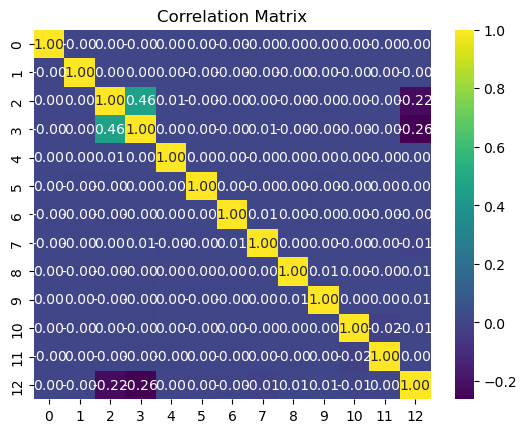



signup_time      109111
purchase_time    100058
device_id        110599
source                3
browser               5
sex                   2
cntry               177
dtype: int64




In [55]:
import random
#2. Exploration of dataset  
#2. 1) Class imbalance 
# Regarding high-level problem statements, the target dataset is a mixture of normal and fraudulent transactions. 
# In the real-world, most of transactions are normal, and only a few transactions are fraudulent. 
# Such class imbalance can be observed in datasets other than the fraud dataset like defects in a manufacturing dataset. 
# I can check size of each class as follows:

size_normal = len(Raw_df[(Raw_df['class'] == 0)])
size_fraud = len(Raw_df[(Raw_df['class'] == 1)])

print(f'The size of normal class is {size_normal}, and that of fraud class is {size_fraud}') 
print('\n')
# The number of normal transactions dominates that of fraudulent ones.
# Since conventional classifier is learned by differences between each class, this imbalance makes it hard to get a rigorous classifier.
# For example, I can check it with a baseline model, which is naive and lack of pre-processing. 
# I did only quantization of categorical features and normalized input for the baseline model.

X = Raw_df.drop('class', axis=1)
y = Raw_df['class']

num_cols = X.select_dtypes(exclude=['object']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# This step is the quantization of categorical features. 'LabelEncoder' gives an incremental value for each categorical value.

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    
scaler = StandardScaler()
X = scaler.fit_transform(X)

Random_seed = random.randint(0,20000)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=Random_seed)

model_baseline = LogisticRegression()
model_baseline.fit(X_train,y_train)

# I can check the accuracy of model by as follows.

model_baseline_Accuracy = model_baseline.score(X_test, y_test)
print(f'The accuracy of baseline model : {model_baseline_Accuracy}')
print('\n')

# Accuracy itself is about 0.9. Since I want to detect fraudulent transactions, however, I need to check the number of detected fraudulents.

fraud_proba = model_baseline.predict_proba(X_test)
fraud_label = model_baseline.predict(X_test)

comp_df = pd.DataFrame({'Actual': y_test, 'Predicted': fraud_label})
detected_frauds = len(comp_df[(comp_df['Actual'] == 1) & (comp_df['Predicted'] == 1)])
total_number_of_frauds = len(comp_df[comp_df['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds} / {total_number_of_frauds}')
print('\n')

# The baseline model cannot detect any fraudulent transaction, which stems from the class imbalance.
# Meanwhile, such imbalance makes it hard to derive a proper correlation between input and output. 

y_ = np.reshape(y, (-1,1))
X_and_Y = np.concatenate((X,y_), axis=1)

correlation_matrix = np.corrcoef(X_and_Y, rowvar=False)
#correlation_matrix = X_and_Y.corr()
# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=range(len(correlation_matrix)), yticklabels=range(len(correlation_matrix)))
plt.title('Correlation Matrix')
plt.show()
print('\n')

# Relavance between Input variables (0-11) and class label (12) can hardly be calculated. 

#2. 2) Cardinality of categorical value
# As you can see in the quantization of the categorical value step, LabelEncoder gives incremental values. 
# If the cardinality of categorical value is too high, it can be hard to get a relevant pattern for defining the class. 

print(Raw_df[cat_cols].nunique())
print('\n')
# I observed many categories in 'signup_time', 'purchase_time', 'device_id', 'cntry'
# Additional feature engineering is required. 
# Two main issues of dataset were : 1) imbalanced data, 2) Too many categorical value 

In [78]:
#3. Improvement steps
#3. 1) Application of Oversampling and giving different cost between classes 
# I can carry out oversampling merely by randomly selecting a minority class since it can trigger overfitting to oversampled instances.
# Instead, I adopted ADASYN (Adaptive Synthetic Sampling Approach) which generates synthetic instances based on the minority class. 
# SMOTE (Synthetic Minority Over-sampling Technique) is a well-known method performing a similar task.  

ADASYN_strategy = {0:size_normal, 1:size_normal} # This policy results in the same number of normal and fraud classes,
# by generating more synthetic instances of the fraud class. 

X_adasyn, y_adasyn = ADASYN(sampling_strategy = ADASYN_strategy).fit_resample(X,y)

X_tr_ADASYN, X_ts_ADASYN, y_tr_ADASYN, y_ts_ADASYN = train_test_split(X_adasyn, y_adasyn, test_size = 0.3,random_state=Random_seed)
# Even though I use the same random seed as the previous split, actual training and test set can be different since I generated
# the synthetic data by ADASYN

# now I can repeat the same step above in #2. 3)

model_ADASYN = LogisticRegression()
model_ADASYN.fit(X_tr_ADASYN, y_tr_ADASYN)

# I am interested in only the number of fraudulent in original dataset detected by revised classifier.
# Thus, I used the original test data and test label.
fr_lab_ADASYN = model_ADASYN.predict(X_test)

comp_df_ADASYN = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_ADASYN})
detected_frauds_ADASYN = len(comp_df_ADASYN[(comp_df_ADASYN['Actual'] == 1) & (comp_df_ADASYN['Predicted'] == 1)])
total_number_of_frauds_ADASYN = len(comp_df_ADASYN[comp_df_ADASYN['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_ADASYN} / {total_number_of_frauds_ADASYN}')
print('\n')
# The same step using weighting between classes can be done as follows.

model_weighted = LogisticRegression(class_weight = 'balanced') # 'balanced' argument implicitly gives weight inverse proportional to class size.
model_weighted.fit(X_train, y_train) 

fr_lab_weighted = model_weighted.predict(X_test)


comp_df_weighted = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_weighted})
detected_frauds_weighted = len(comp_df_weighted[(comp_df_weighted['Actual'] == 1) & (comp_df_weighted['Predicted'] == 1)])
total_number_of_frauds_weighted = len(comp_df_weighted[comp_df_weighted['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_weighted} / {total_number_of_frauds_weighted}')

# Although ADASYN shows slightly better performance, this dominance can be varied by dataset.
# In terms of Computational efficiency, ADASYN requires more computing resources.

#3. 2) Feature engineering
# At first, I need to drop redundant features which give a burden of calculation and hinder the performance of algorithm. 
# Unnamed: 0 column is not labeled what it means. Maybe it is an index or annotation based on order. 
# user_id is not a relevant feature since the fraud can generate user_id easily. 
# ip_address is mapped as cntry column. Thus I can drop it also. 
# Let's check if the performance of classifier is maintained despite of deletion of these features
# The column number of three elements are 0, 1, 10 
X_train_drop = np.delete(X_train, [0,1,10], axis=1)
X_test_drop = np.delete(X_test, [0,1,10], axis=1)

model_weighted_drop = LogisticRegression(class_weight = 'balanced')
model_weighted_drop.fit(X_train_drop, y_train)
fr_lab_weighted_drop = model_weighted_drop.predict(X_test_drop)

comp_df_weighted_drop = pd.DataFrame({'Actual': y_test, 'Predicted': fr_lab_weighted_drop})
detected_frauds_weighted_drop = len(comp_df_weighted_drop[(comp_df_weighted_drop['Actual'] == 1) & (comp_df_weighted_drop['Predicted'] == 1)])
total_number_of_frauds_weighted_drop = len(comp_df_weighted_drop[comp_df_weighted_drop['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_weighted_drop} / {total_number_of_frauds_weighted_drop}')

# I can reduce dimensionality by no information loss.



The number of properly predicted fraudulent : 2445 / 3343


The number of properly predicted fraudulent : 2303 / 3343
The number of properly predicted fraudulent : 2303 / 3343


Mean and std_dev time gap of normal transaction : 1442.1264477859015 / 830.7106440839449


Mean and std_dev time gap of fraud transaction : 677.0915209350495 / 921.9098595772921


36.862344231388235
37.066134043497556


Mean and std_dev time gap of normal device use : 1.0945509725479377 / 0.667622668373004


Mean and std_dev time gap of fraud device use : 5.856901908566356 / 4.697917646065942
Country=United States, n=4472 (0.397%)
Country=Unknown, n=1483 (0.132%)
Country=China, n=817 (0.073%)
Country=Japan, n=554 (0.049%)
Country=United Kingdom, n=372 (0.033%)
Country=Korea Republic of, n=306 (0.027%)
Country=Canada, n=270 (0.024%)
Country=France, n=233 (0.021%)
Country=Brazil, n=218 (0.019%)
Country=Germany, n=211 (0.019%)
Country=Australia, n=135 (0.012%)
Country=Italy, n=133 (0.012%)
Country=India, n=117 (0.010%)
Country=Mexico, n=113 (0.010%)
Country=Sweden, n=107 (0.009%)
Country=Netherlands, n=100 (0.009%)
Country=Russian Federation, n=100 (0.009%)
Country=Taiwan; Republic of Chi

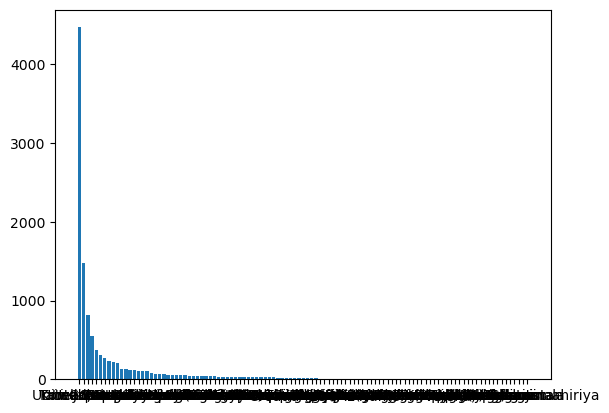

Country=United States, n=46184 (0.385%)
Country=Unknown, n=17418 (0.145%)
Country=China, n=9532 (0.079%)
Country=Japan, n=5735 (0.048%)
Country=United Kingdom, n=3580 (0.030%)
Country=Korea Republic of, n=3341 (0.028%)
Country=Germany, n=2890 (0.024%)
Country=France, n=2489 (0.021%)
Country=Brazil, n=2353 (0.020%)
Country=Canada, n=2344 (0.020%)
Country=Italy, n=1564 (0.013%)
Country=Australia, n=1491 (0.012%)
Country=Netherlands, n=1325 (0.011%)
Country=Russian Federation, n=1281 (0.011%)
Country=India, n=1014 (0.008%)
Country=Taiwan; Republic of China (ROC), n=967 (0.008%)
Country=Mexico, n=919 (0.008%)
Country=Spain, n=842 (0.007%)
Country=Sweden, n=842 (0.007%)
Country=South Africa, n=655 (0.005%)
Country=Switzerland, n=639 (0.005%)
Country=Poland, n=586 (0.005%)
Country=Indonesia, n=520 (0.004%)
Country=Argentina, n=513 (0.004%)
Country=Norway, n=480 (0.004%)
Country=Colombia, n=471 (0.004%)
Country=Turkey, n=456 (0.004%)
Country=Viet Nam, n=431 (0.004%)
Country=Romania, n=415 (0.

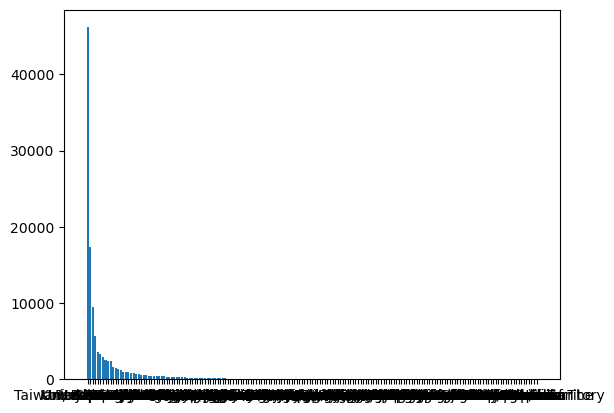

,Country,n_df1,n_df2,ratio
98,Bulgaria,1,130,0.007692
87,Serbia,1,50,0.020000
72,Morocco,3,134,0.022388
97,Cyprus,1,31,0.032258
78,Belarus,2,59,0.033898
...,...,...,...,...
63,Sri Lanka,8,22,0.363636
47,Luxembourg,22,56,0.392857
59,Namibia,8,20,0.400000
85,Virgin Islands (U.S.),1,2,0.500000


In [46]:
# In addition, I do feature Engineering for Categorical values with high cardinality.
# The first group is signup_time and purchase_time. 
# I want to analyze not raw values of two features, but the difference between two datetimes. 
# I can calculate and compare the difference as follows. 

def time_gap_calculation(target_df):
    signup_df = pd.to_datetime(Raw_df['signup_time'])
    purchase_df = pd.to_datetime(Raw_df['purchase_time'])
    time_diff = (purchase_df - signup_df).dt.total_seconds()/3600
    return time_diff


time_diff_df = time_gap_calculation(Raw_df)
mean_normal_time = time_diff_df.loc[(Raw_df['class']==0)].mean()
std_normal_time = time_diff_df.loc[(Raw_df['class']==0)].std()
mean_fraud_time = time_diff_df.loc[(Raw_df['class']==1)].mean()
std_fraud_time = time_diff_df.loc[(Raw_df['class']==1)].std()

print(f'Mean and std_dev time gap of normal transaction : {mean_normal_time} / {std_normal_time}')
print('\n')
print(f'Mean and std_dev time gap of fraud transaction : {mean_fraud_time} / {std_fraud_time}')

# Time gap between two classes are significant.

# I can do a similar job to the purchase value column.
# However, the purchase value of normal and fraud seems not to be different.
print('\n')
print(Raw_df['purchase_value'].loc[(Raw_df['class']==0)].mean())
print(Raw_df['purchase_value'].loc[(Raw_df['class']==1)].mean())
print('\n')
# The next one is device_id. If someone create many user_id with the same device, it can be suspicious.
# I can do the same routine.

device_used_df = Raw_df.groupby('device_id')['device_id'].transform('count')
mean_normal_use = device_used_df.loc[(Raw_df['class']==0)].mean()
mean_fraud_use = device_used_df.loc[(Raw_df['class']==1)].mean()
std_normal_use = device_used_df.loc[(Raw_df['class']==0)].std()
std_fraud_use = device_used_df.loc[(Raw_df['class']==1)].std()
print(f'Mean and std_dev time gap of normal device use : {mean_normal_use} / {std_normal_use}')
print('\n')
print(f'Mean and std_dev time gap of fraud device use : {mean_fraud_use} / {std_fraud_use}')


# (Incomplete) The last one is country. I intended to re-categorize country with 3-4 values. 

Fraud_cntry = Fraud_df['cntry']

Normal_df = Raw_df.loc[(Raw_df['class']==0)]
Normal_cntry = Normal_df['cntry']

print('\n')
def count_and_plot(y): 
    counter = Counter(y)
    
    # Sort the items in the counter dictionary by frequency in descending order
    sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    data = {'Country': list(sorted_counter.keys()), 'n': list(sorted_counter.values())}
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    for k, v in sorted_counter.items():
        print('Country=%s, n=%d (%.3f%%)' % (k, v, v / len(y)))
    
    # Plot the sorted counter
    plt.bar(sorted_counter.keys(), sorted_counter.values())
    plt.show()
    
    # Return the DataFrame
    return df

Fraud_cntry_counter = count_and_plot(Fraud_cntry)
All_cntry_counter = count_and_plot(Raw_df['cntry'])
merged_df = pd.merge(Fraud_cntry_counter, All_cntry_counter, on='Country', how='left', suffixes=('_df1', '_df2'))
merged_df['ratio'] = merged_df['n_df1'] / merged_df['n_df2']
merged_df.loc[merged_df['n_df1'].isnull(), 'ratio'] = 0
merged_df.sort_values(by='ratio')

# My intension is to re-categorize country categories by using information of merged_df. 

In [80]:
import torch.nn as nn
import torch.optim as optim
# New feature Engineered Raw df 
New_df = Raw_df.drop(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'purchase_value', 'ip_address'], axis=1)
New_df['time_gap'] = time_gap_calculation(Raw_df)
New_df['device_used_counter'] = Raw_df.groupby('device_id')['device_id'].transform('count')
New_df

#3. 3) Additional model implementation. 
# At first, I can check Logistic regression with cost functionusing 'new_df'
X_new = New_df.drop('class', axis=1)
y_new = New_df['class']

num_cols_new = X_new.select_dtypes(exclude=['object']).columns
cat_cols_new = X_new.select_dtypes(include=['object']).columns

# This step is the quantization of categorical features. 'LabelEncoder' gives an incremental value for each categorical value.

label_encoders = {}

for col in cat_cols_new:
    le = LabelEncoder()
    X_new[col] = le.fit_transform(X_new[col])
    label_encoders[col] = le
    
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.3,random_state=Random_seed)
scaler = StandardScaler()
X_train_new[num_cols_new] = scaler.fit_transform(X_train_new[num_cols_new])
X_test_new[num_cols_new] = scaler.transform(X_test_new[num_cols_new])

ADASYN_strategy = {0:size_normal, 1:size_normal} # This policy results in the same number of normal and fraud classes,

X_adasyn, y_adasyn = ADASYN(sampling_strategy = ADASYN_strategy).fit_resample(X_new,y_new)

X_tr_ADASYN, X_ts_ADASYN, y_tr_ADASYN, y_ts_ADASYN = train_test_split(X_adasyn, y_adasyn, test_size = 0.3,random_state=Random_seed)

model_ADASYN = LogisticRegression()
model_ADASYN.fit(X_tr_ADASYN, y_tr_ADASYN)

model_new = LogisticRegression(class_weight = 'balanced')
model_new.fit(X_train_new, y_train_new)
fr_lab_new = model_new.predict(X_test_new)

comp_df_new = pd.DataFrame({'Actual': y_test_new, 'Predicted': fr_lab_new})
detected_frauds_new = len(comp_df_new[(comp_df_new['Actual'] == 1) & (comp_df_new['Predicted'] == 1)])
total_number_of_frauds_new = len(comp_df_new[comp_df_new['Actual']==1])
print(f'The number of properly predicted fraudulent : {detected_frauds_new} / {total_number_of_frauds_new}')

# Performance seems to be a little bit reduced, but it is only a performance of baseline model. 
# I can now apply different models. 
# I want to use simple neural network model. 
# For using pytorch, I firstly transfer data as tensor. 

X_train_ts = torch.tensor(X_train_new.values, dtype = torch.float32)
y_train_ts = torch.tensor(y_train_new.values, dtype = torch.float32)
X_test_ts = torch.tensor(X_test_new.values, dtype = torch.float32)
y_test_ts = torch.tensor(y_test_new.values, dtype = torch.float32)
# 
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size,hidden_num):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_num)
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_num, hidden_num*2)
        self.fc3 = nn.Linear(hidden_num*2, 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLu(x)
        x = self.fc2(x)
        x = self.ReLu(x)
        x = self.fc3(x)
        x = self.Sigmoid(x)
        return x 
    

input_size = X_train_ts.shape[1]
hidden_num = 30
model = BinaryClassificationModel(input_size, hidden_num)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    outputs = model(X_train_ts)
    loss = criterion(outputs, y_train_ts.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



C:\ProgramData\anaconda3\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The number of properly predicted fraudulent : 2269 / 3343
Epoch [100/1000], Loss: 0.2275
Epoch [200/1000], Loss: 0.1884
Epoch [300/1000], Loss: 0.1792
Epoch [400/1000], Loss: 0.1756
Epoch [500/1000], Loss: 0.1733
Epoch [600/1000], Loss: 0.1723
Epoch [700/1000], Loss: 0.1716
Epoch [800/1000], Loss: 0.1707
Epoch [900/1000], Loss: 0.1704
Epoch [1000/1000], Loss: 0.1698


In [75]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test_ts)
    predictions = (predictions>= 0.5).float()

fr_lab_new = predictions.numpy()
fr_lab_new = np.reshape(fr_lab_new,(-1,1))


# My mvp is using using features of new_df and ADASYN. 



ValueError: Per-column arrays must each be 1-dimensional

In [101]:
def IP_Country_map(Target_df, Cntry_df):
    output = Target_df['ip_address'].apply(lambda x: Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) 
                                                                    & (x <= Cntry_df['upper_bound_ip_address']), 'country'].values[0] 
                                             if not Cntry_df.loc[(Cntry_df['lower_bound_ip_address'] <= x) & 
                                                                 (x <= Cntry_df['upper_bound_ip_address']), 'country'].empty else None)
    return output

Holdout_df = pd.read_csv('fraud_holdout_no_label.csv')
Holdout_df['cntry'] = IP_Country_map(Raw_df, Cntry_df)

Sub_df = Holdout_df.drop(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'purchase_value', 'ip_address'], axis=1)
Sub_df['time_gap'] = time_gap_calculation(Holdout_df)
Sub_df['device_used_counter'] = Raw_df.groupby('device_id')['device_id'].transform('count')

# Label Encoding and normalization with Sub_df
label_encoders = {}

for col in cat_cols_new:
    le = LabelEncoder()
    Sub_df[col] = le.fit_transform(Sub_df[col])
    label_encoders[col] = le
scaler = StandardScaler()
Sub_df = scaler.fit_transform(Sub_df)

# The below error was fixed

C:\ProgramData\anaconda3\envs\torch\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Ads'

In [105]:
# Training ADASYN with new features
X_new = New_df.drop('class', axis=1)
y_new = New_df['class']

num_cols_new = X_new.select_dtypes(exclude=['object']).columns
cat_cols_new = X_new.select_dtypes(include=['object']).columns

# This step is the quantization of categorical features. 'LabelEncoder' gives an incremental value for each categorical value.

label_encoders = {}

for col in cat_cols_new:
    le = LabelEncoder()
    X_new[col] = le.fit_transform(X_new[col])
    label_encoders[col] = le
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)


X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.3,random_state=Random_seed)

ADASYN_strategy = {0:size_normal, 1:size_normal} # This policy results in the same number of normal and fraud classes,

X_adasyn, y_adasyn = ADASYN(sampling_strategy = ADASYN_strategy).fit_resample(X_new,y_new)

X_tr_ADASYN, X_ts_ADASYN, y_tr_ADASYN, y_ts_ADASYN = train_test_split(X_adasyn, y_adasyn, test_size = 0.3,random_state=Random_seed)

model_ADASYN = LogisticRegression()
model_ADASYN.fit(X_tr_ADASYN, y_tr_ADASYN)


label_sub = model_ADASYN.predict(Sub_df)
label_prob = model_ADASYN.predict_proba(Sub_df)

df1 = pd.DataFrame(label_sub)
df2 = pd.DataFrame(label_prob)
df1.to_csv('Label_holdout.csv')
df2.to_csv('LabelP_holdout.csv')